In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-nonlineqn-rootproblem)=
# The rootfinding problem

For the time being we will focus on the **rootfinding problem** for single functions of one variable.

```{index} ! rootfinding problem
```

```{proof:definition} Rootfinding problem
Given a continuous scalar function $f$ of a scalar variable, find a real number $r$, called a **root**, such that $f(r)=0$.
```

The formulation $f(x)=0$ is general enough to solve any equation. If we are trying to solve an equation $g(x)=h(x)$, we can define $f=g-h$ and find a root of $f$.

```{index} ! Julia; nlsolve
```

Unlike the linear problems of the earlier chapters, the usual situation here is that the root cannot be produced in a finite number of operations, even in exact arithmetic. Instead, we seek a sequence of approximations that formally converge to the root, stopping when some member of the sequence seems to be good enough, in a sense we will clarify later. The `NLsolve` package for Julia has a function `nlsolve` for general-purpose rootfinding.

(demo-rootproblem-bessel)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

In the theory of vibrations of a circular drum, the displacement of the drumhead can be expressed in terms of pure harmonic modes, 

$$J_m(\omega_{k,m} r) \cos(m\theta) \cos(c \omega_{k,m} t),$$

where $(r,\theta)$ are polar coordinates, $0\le r\le 1$, $t$ is time, $m$ is a positive integer, $c$ is a material parameter, and $J_m$ is a _Bessel function of the first kind_. The quantity $\omega_{k,m}$ is a resonant frequency and is a positive root of the equation  

$$J_m(\omega_{k,m}) = 0,$$ 

which states that the drumhead is clamped around the rim. Bessel functions often appear in physical problems featuring radial symmetry, and tabulating approximations to the zeros of Bessel functions occupied numerous mathematician-hours before computers were on the scene.

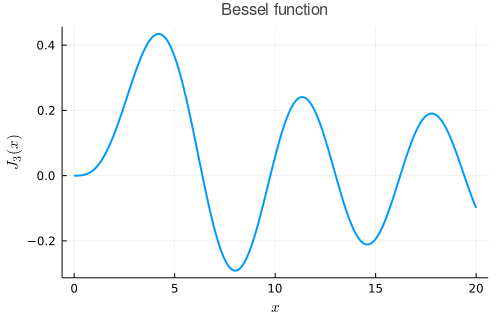

In [2]:
J3(x) = besselj(3,x)
plot(J3,0,20,title="Bessel function",
    xaxis=(L"x"),yaxis=(L"J_3(x)"),grid=:xy)

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
From the graph we see roots near 6, 10, 13, 16, and 19. We use `nlsolve` from the `NLsolve` package to find these roots accurately. It uses vector variables, so we have to code accordingly.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
Type `\omega` followed by <kbd>Tab</kbd> to get the character `ω`.

The argument `ftol=1e-14` below is called a **keyword argument**. Here it sets a goal for the maximum value of $|f(x)|$.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [3]:
ω = []
for guess = [6.,10.,13.,16.,19.]
    s = nlsolve(x->besselj(3,x[1]),[guess],ftol=1e-14)
    append!(ω,s.zero)
end

In [4]:
pretty_table([ω J3.(ω)],["root estimate" "function value"])

┌───────────────┬────────────────┐
│ root estimate │ function value │
├───────────────┼────────────────┤
│       6.38016 │    2.47025e-15 │
│       9.76102 │            0.0 │
│       13.0152 │   -2.77556e-17 │
│       16.2235 │    6.93889e-18 │
│       19.4094 │   -9.71445e-17 │
└───────────────┴────────────────┘


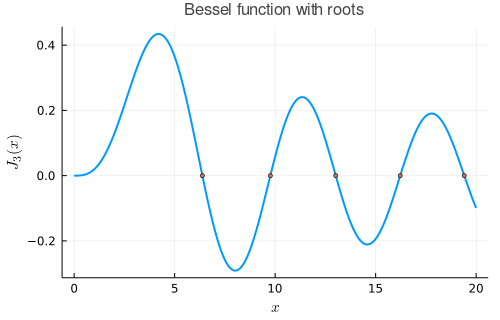

In [5]:
scatter!(ω,J3.(ω),title="Bessel function with roots")

If instead we seek values at which $J_3(x)=0.2$, then we must find roots of the function $J_3(x)-0.2$.

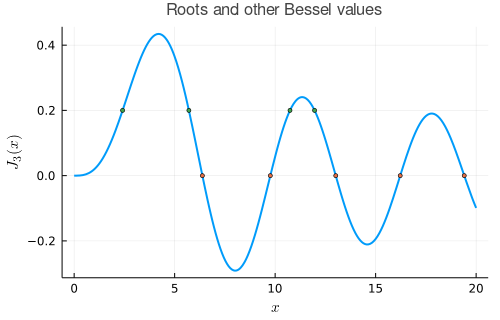

In [6]:
r = []
for guess = [3.,6.,10.,13.]
    f = x -> besselj(3,x[1])-0.2
    s = nlsolve(f,[guess],ftol=1e-14)
    append!(r,s.zero)
end
scatter!(r,J3.(r),title="Roots and other Bessel values")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Conditioning, error, and residual

In the rootfinding problem, the data is a continuous function $f$ and the result is a root. (This overrides our Chapter 1 notation of $f$ as the map from data to result.) How does the result change in response to perturbations in $f$? We will compute an absolute condition number rather than a relative one.

You might wonder about the relevance of perturbing a function as data to a problem. If nothing else, the values of $f$ will be represented in floating point and thus subject to rounding error. Furthermore, in many applications, $f$ might not be a simple formula but the result of a computation that uses an inexact algorithm. While there are infinitely many possible perturbations to a function, a constant perturbation is enough to get the main idea.

We assume $f$ has at least one continuous derivative near a particular root $r$. Suppose that $f$ is perturbed to $\tilde{f}(x) = f(x) + \epsilon$. As a result, the root (if it still exists) will be perturbed to $\tilde{r} = r + \delta$ such that $\tilde{f}(\tilde{r})=0$. We now compute an absolute condition number $\kappa_r$, which is the ratio $\left | \frac{\delta}{\epsilon} \right|$ as $\epsilon\to 0$.

Using Taylor's theorem,

```{math}
  0 = f(r+\delta) + \epsilon \approx f(r) + f'(r) \delta + \epsilon.
```

Since $r$ is a root, we have $f(r)=0$. This lets us relate $\delta$ to $\epsilon$, and their ratio is the condition number.

```{index} condition number; of rootfinding
```

````{proof:theorem} Condition number of rootfinding
If $f$ is differentiable at a root $r$, then the absolute condition number of $r$ with respect to constant changes in $f$ is

```{math}
  :label: rootcondnum
  \kappa_r = \bigl| f'(r) \bigr|^{-1}.
```

We say $\kappa_r = \infty$ if $f'(r)=0$.
````

Equivalently, {eq}`rootcondnum` is just the magnitude of the derivative of the inverse function $f^{-1}$ at zero. 


(demo-roots-cond)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Consider first the function

In [7]:
f  = x -> (x-1)*(x-2);

:::{index} ! Julia; splatting
:::

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
At the root $r=1$, we have $f'(r)=-1$. If the values of $f$ were perturbed at every point by a small amount of noise, we can imagine finding the root of the function drawn with a thick ribbon, giving a range of potential roots.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The syntax `interval...` is called **splatting** and means to insert all the individual elements of `interval` as a sequence.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

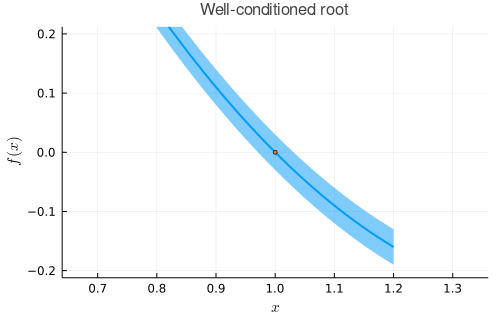

In [8]:
interval = [0.8,1.2]

plot(f,interval...,ribbon=0.03,aspect_ratio=1,
    xlabel=L"x",yaxis=(L"f(x)",[-0.2,0.2]))

scatter!([1],[0],title="Well-conditioned root")

The possible values for a perturbed root all lie within the interval where the ribbon intersects the $x$-axis. The width of that zone is about the same as the vertical thickness of the ribbon.

By contrast, consider the function

In [9]:
f = x -> (x-1)*(x-1.01);

Now $f'(1)=-0.01$, and the graph of $f$ will be much shallower near $x=1$. Look at the effect this has on our thick rendering:

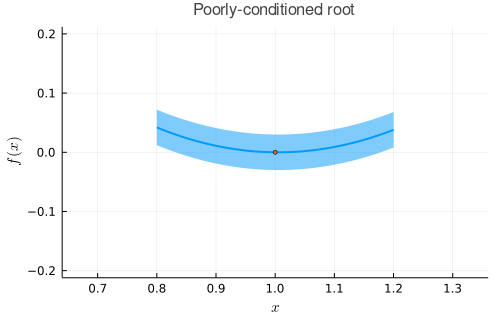

In [10]:
plot(f,interval...,ribbon=0.03,aspect_ratio=1,
    xlabel=L"x",yaxis=(L"f(x)",[-0.2,0.2]))

scatter!([1],[0],title="Poorly-conditioned root")

The vertical displacements in this picture are exactly the same as before. But the potential _horizontal_ displacement of the root is much wider. In fact, if we perturb the function entirely upward by the amount drawn here, the root disappears!
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


```{index} ! residual; of rootfinding
```

We must accept that when $|f'|$ is small at the root, it may not be possible to get a small error in a computed root estimate. As always, the error is not a quantity we can compute without knowing the exact answer. There is something else we can measure, though.

::::{proof:definition} Rootfinding residual
If $\tilde{r}$ approximates a root $r$ of function $f$, then the **residual** at $\tilde{r}$ is $f(\tilde{r})$.
::::

It stands to reason that a small residual might be associated with a small error. To quantify the relationship, let $\tilde{r}$ approximate root $r$, and define the new function $g(x)=f(x)-f(\tilde{r})$. Trivially, $g(\tilde{r})=0$, meaning that $\tilde{r}$ is a true root of $g$. Since the difference $g(x)-f(x)$ is the residual value $f(\tilde{r})$, the residual is the distance to an exactly solved rootfinding problem. 

```{index} backward error
```

```{proof:observation}
The backward error in a root estimate is equal to the residual.
```

In general, it is not realistic to expect a small error in a root approximation if the condition number {eq}`rootcondnum` is large. However, we can gauge the backward error from the residual.

## Multiple roots

```{index} ! roots; multiplicity of
```

The condition number {eq}`rootcondnum` naturally leads to the question of what happens if $f'(r)=0$ at a root $r$. The following definition agrees with and extends the notion of algebraic multiplicity in a polynomial to roots of more general differentiable functions. 

(definition-rootproblem-simple)=
::::{proof:definition} Multiplicity of a root
If $f(r)=f'(r)=\cdots=f^{(m-1)}(r)=0$, but $f^{(m)}(r)\neq 0$, then we say $f$ has a root of **multiplicity** $m$ at $r$. In particular, if $f(r)=0$ and $f'(r)\neq 0$, then $m=1$ and we call $r$ a **simple root**.
::::

Another useful characterization of multiplicity $m$ is that $f(x)=(x-r)^m q(x)$ for a differentiable $q$ with $q(r)\neq 0$. 

When $r$ is a nonsimple root, the condition number {eq}`rootcondnum` is effectively infinite.[^infcond] However, even if $r$ is simple, we should expect difficulty in rootfinding if the condition number is very large. This occurs when $|f'(r)|$ is very small, which means that the quotient $q$ satisfies $q(r)\approx 0$ and another root of $f$ is very close to $r$. We made the same observation about polynomial roots all the way back in {numref}`Demo {number} <demo-stability-roots>`. 

[^infcond]: Based on our definitions, this means that the relative change to the root when $f$ is changed by a perturbation of size $\epsilon$ is not $O(\epsilon)$ as $\epsilon\to 0$.

## Exercises

⌨  For each equation and given interval, do the following steps.
  
**(a)** Rewrite the equation into the standard form for rootfinding, $f(x) = 0$. Make a plot of $f$ over the given interval and determine how many roots lie in the interval. 
  
**(b)**  Use `nlsolve` to find each root, as shown in {numref}`Demo {number} <demo-rootproblem-bessel>`.

**(c)** Compute the condition number of each root found in part (b). 

1. $x^2=e^{-x}$, over $[-2,2]$

2. $2x = \tan x$, over $[-0.2,1.4]$
  
3. $e^{x+1}=2+x$, over $[-2,2]$
  
    ---

4. ⌨ A basic safe type of investment is an annuity: one makes monthly deposits of size $P$ for $n$ months at a fixed annual interest rate $r$, and at maturity collects the amount
  
    $$
    \frac{12 P}{r} \left( \Bigl(1+\frac{r}{12}\Bigr)^n - 1\right).
    $$

    Say you want to create an annuity for a term of 300 months and final value of \$1,000,000. Using `nlsolve`, make a table of the interest rate you will need to get for each of the different contribution values $P=500,550,\ldots,1000$.  

5. ⌨ The most easily observed properties of the orbit of a celestial body around the sun are the period $\tau$ and the elliptical eccentricity $\epsilon$. (A circle has $\epsilon=0$.) From these, it is possible to find at any time $t$ the angle $\theta(t)$ made between the body's position and the major axis of the ellipse. This is done through
  
    ```{math}
    :label: kepler1
    \tan \frac{\theta}{2} = \sqrt{\frac{1+\epsilon}{1-\epsilon}}\,
    \tan \frac{\psi}{2},
    ```

    where the eccentric anomaly $\psi(t)$ satisfies Kepler's equation:
  
    ```{math}
    :label: kepler2
    \psi - \epsilon \sin \psi - \frac{2\pi t}{\tau} = 0.
    ```

    Equation {eq}`kepler2` must be solved numerically to find $\psi(t)$, and then {eq}`kepler1` can be solved analytically to find $\theta(t)$.

    The asteroid Eros has $\tau=1.7610$ years and $\epsilon=0.2230$. Using `nlsolve` for {eq}`kepler2`, make a plot of $\theta(t)$ for 100 values of $t$ between $0$ and $\tau$, which is one full orbit. (Note: Use `mod(θ,2π)` to put the angle between 0 and $2\pi$ if you want the result to be a continuous function.)
   
6. ⌨  Lambert's $W$ function is defined as the inverse of $x e^x$. That is, $y=W(x)$ if and only if $x=ye^y$. Write a function `lambertW` that computes $W$ using `nlsolve`. Make a plot of $W(x)$ for $0\le x \le 4$.  

7. ✍ For each function, find the multiplicity of the given root. If it is a simple root, find its absolute condition number.
  
    **(a)** $f(x) = x^3-2x^2+x-2$, root $r=2$

    **(b)** $f(x) = (\cos x  + 1)^2$, root $r=\pi$

    **(c)** $f(x) = \frac{\sin^2 x}{x}$, root $r=0$ (define $f(0) =0$)

    **(d)** $f(x) =(x-1)\log(x)$, root $r=1$